# 3) POS Pattern Frequency (Adj+N, V+N, etc.)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Analyze grammatical patterns in bigrams using Part-of-Speech (POS) tagging.
- Identify common POS patterns like ADJ+NOUN, VERB+NOUN, NOUN+NOUN across two works by the same author.
- Visualize the distribution of POS patterns to understand syntactic phrase structure.

Learning objectives:
- Apply spaCy POS tagging to tokenized text for grammatical analysis.
- Compute and compare POS bigram patterns across literary texts.
- Visualize syntactic patterns to identify stylistic features.
- Understand how preprocessing choices (stopwords, filtering) affect syntactic analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. Ensure `en_core_web_sm` spaCy model is installed (included in requirements.txt).

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, spacy).
- spaCy English model: `en_core_web_sm` (should be installed via requirements.txt).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- POS tagging can be slow on large texts; consider slicing tokens or processing in chunks.
- Common patterns: ADJ+NOUN (descriptive phrases), VERB+NOUN (action phrases), NOUN+NOUN (compounds).
- Compare patterns between your two books to see if syntactic style differs.
- For non-English texts, change the spaCy model in the CONFIG or POS tagging cell (e.g., `de_core_news_sm` for German).

**Goal:** Identify and visualize the most frequent Part-of-Speech bigram patterns (e.g., ADJ+NOUN, VERB+NOUN) in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [16]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Wonderland.txt",  # <-- change
    "book2_path": "../data/Looking-Glass.txt",  # <-- change
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [17]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [18]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

len(tokens1), len(tokens2), len(tokens)

len(tokens), tokens[:12]


(58137,
 ['illustration',
  'alice',
  's',
  'adventures',
  'in',
  'wonderland',
  'by',
  'lewis',
  'carroll',
  'the',
  'millennium',
  'fulcrum'])

## 2. POS Tagging Setup

Uses spaCy. For English: `en_core_web_sm`. For other languages, switch to an appropriate model. `en_core_web_sm` should be downloaded for you if you followed the requirements.txt requirements.


In [19]:
import spacy
# Change model as needed (e.g., 'de_core_news_sm', 'ru_core_news_sm')
nlp = spacy.load("en_core_web_sm")

# For speed, you can slice tokens (e.g., first 100k tokens)
doc = nlp(" ".join(tokens))  # consider chunking for very large texts

pairs = []
for i in range(len(doc)-1):
    a, b = doc[i], doc[i+1]
    if a.is_alpha and b.is_alpha:
        pairs.append(f"{a.pos_}+{b.pos_}")

pat_counts = Counter(pairs)
pos_df = (pd.DataFrame(pat_counts.items(), columns=["pattern","count"])
            .sort_values("count", ascending=False)
            .head(CONFIG["top_k"]))
pos_df.reset_index(drop=True)

,pattern,count
0,DET+NOUN,3758
1,PRON+VERB,3228
2,VERB+PRON,2265
3,ADP+DET,2128
4,VERB+ADP,2105
5,PRON+AUX,1909
6,NOUN+ADP,1740
7,ADJ+NOUN,1659
8,VERB+DET,1578
9,NOUN+VERB,1525


## 3. Visualize Top POS Patterns

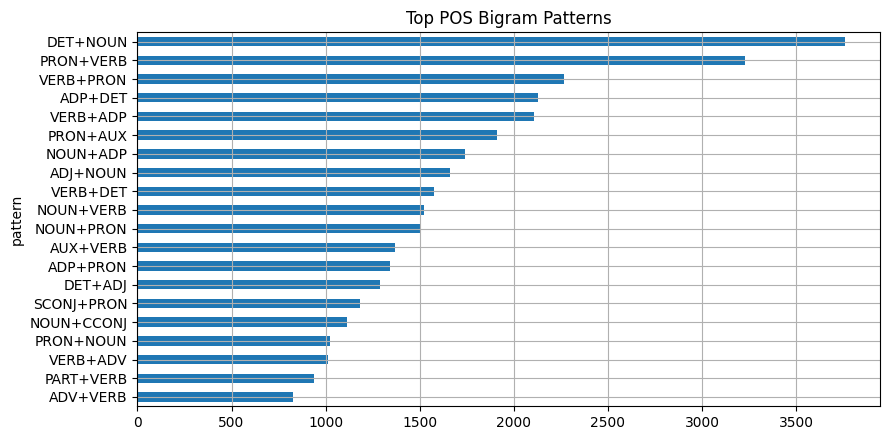

In [20]:
ax = pos_df.plot.barh(x="pattern", y="count", legend=False)
ax.invert_yaxis()
ax.set_title("Top POS Bigram Patterns")
plt.tight_layout(); plt.show()

## 4. Notes

- Useful patterns: `ADJ+NOUN`, `NOUN+NOUN`, `VERB+NOUN`, `PRON+VERB`.
- Compare across your two works by running the same code on `text1` and `text2` separately.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [21]:
Path("../results").mkdir(exist_ok=True)
pos_df.to_csv(f"../results/POS_patterns_table.csv", index=False)
plt.savefig(f"../results/POS_patterns_figure.png", dpi=200, bbox_inches="tight")


<Figure size 900x450 with 0 Axes>